C-to-Python
===

The traditonal way to extend Python with C code is to use the [ctypes](https://docs.python.org/3/library/ctypes.html) package which provides tools to build an interface between the two languages and to directly call functions in a shared library.

The code below uses:
* [ctypes](https://docs.python.org/3/library/ctypes.html)
* [numpy](https://numpy.org/)
* [Pillow](https://pypi.org/project/Pillow/)

This directory contains a Python module mypylib.py and identical code in C/C++ in mylib.cpp(h).  Look over the code before you begin.  And type *make* to build the C/C++ libraries for this example.  Two versions of the shared library are built, one with C-style linkage mylib.soc and one with C++ style linkage mylib.so.

In [1]:
import mypylib
import numpy as np

Estimating pi using uniform random numbers
-----

We'll first measure the time of Python code with our findPi function.  We use 100M random numbers thrown in a unit square to estimate the value of pi.

In [2]:
%time PI=mypylib.findPi(100*1000*1000)
print("Estimate for pi:",PI)

CPU times: user 5.28 s, sys: 20.8 ms, total: 5.3 s
Wall time: 5.31 s
Estimate for pi: 3.14132556


Next we'll use the same code written in C and called from our shared library.

First look at the interfae to our findPi function in C <br>
double findPi(long nthrows);<br>
This takes a long int as input and returns a double value.  To use this function we must define this interface using ctypes data objects.

In [3]:
from ctypes import cdll  # pythonic interfaces for C(++) libraries
from ctypes import c_double
from ctypes import c_long

# load our library and define the input/output interfaces
myclib=cdll.LoadLibrary('./mylib.soc')
myclib.findPi.argtypes = [c_long]
myclib.findPi.restype=c_double

That's it.  Now we can use our C version of findPi directly from Python

In [4]:
%time PI=myclib.findPi(100*1000*1000)
print("Estimate for pi:",PI)

CPU times: user 244 ms, sys: 2.7 ms, total: 247 ms
Wall time: 247 ms
Estimate for pi: 3.1415042


Example 2: Visualizing the Mandelbrot Set
---

We'll begin with a pure python example to draw the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set).

The Python interface is:

def mandel(img, re1, re2, im1, im2, nr, ni, NTRIALS=255)<br>
* img = image array[npX][npY]
* re1, re2 = range to explore on real axis
* im1, im2 = range to explore in imaginary axis
* nr, ni = number of divisions in re/im ranges
* NTRIALS = numebr of iterrations to easimate if a point is included in the set

In [5]:
import numpy as np
# define parameters for the calulation
npX=2000   # 2000 x 2000 pixel image
npY=2000
nTrials=255
re1=-2.1
re2=0.6
im1=-1.5
im2=1.5
img=np.ndarray(shape=(npX,npY), dtype=np.double) # array to hold our image

In [6]:
%time mypylib.mandel(img,re1,re2,im1,im2,npX,npY,nTrials) # this will take a moment....

CPU times: user 19.3 s, sys: 70.4 ms, total: 19.4 s
Wall time: 19.4 s


Next, let's make a nice picture.  I'll leave it as an optional exercise if you want to add color.

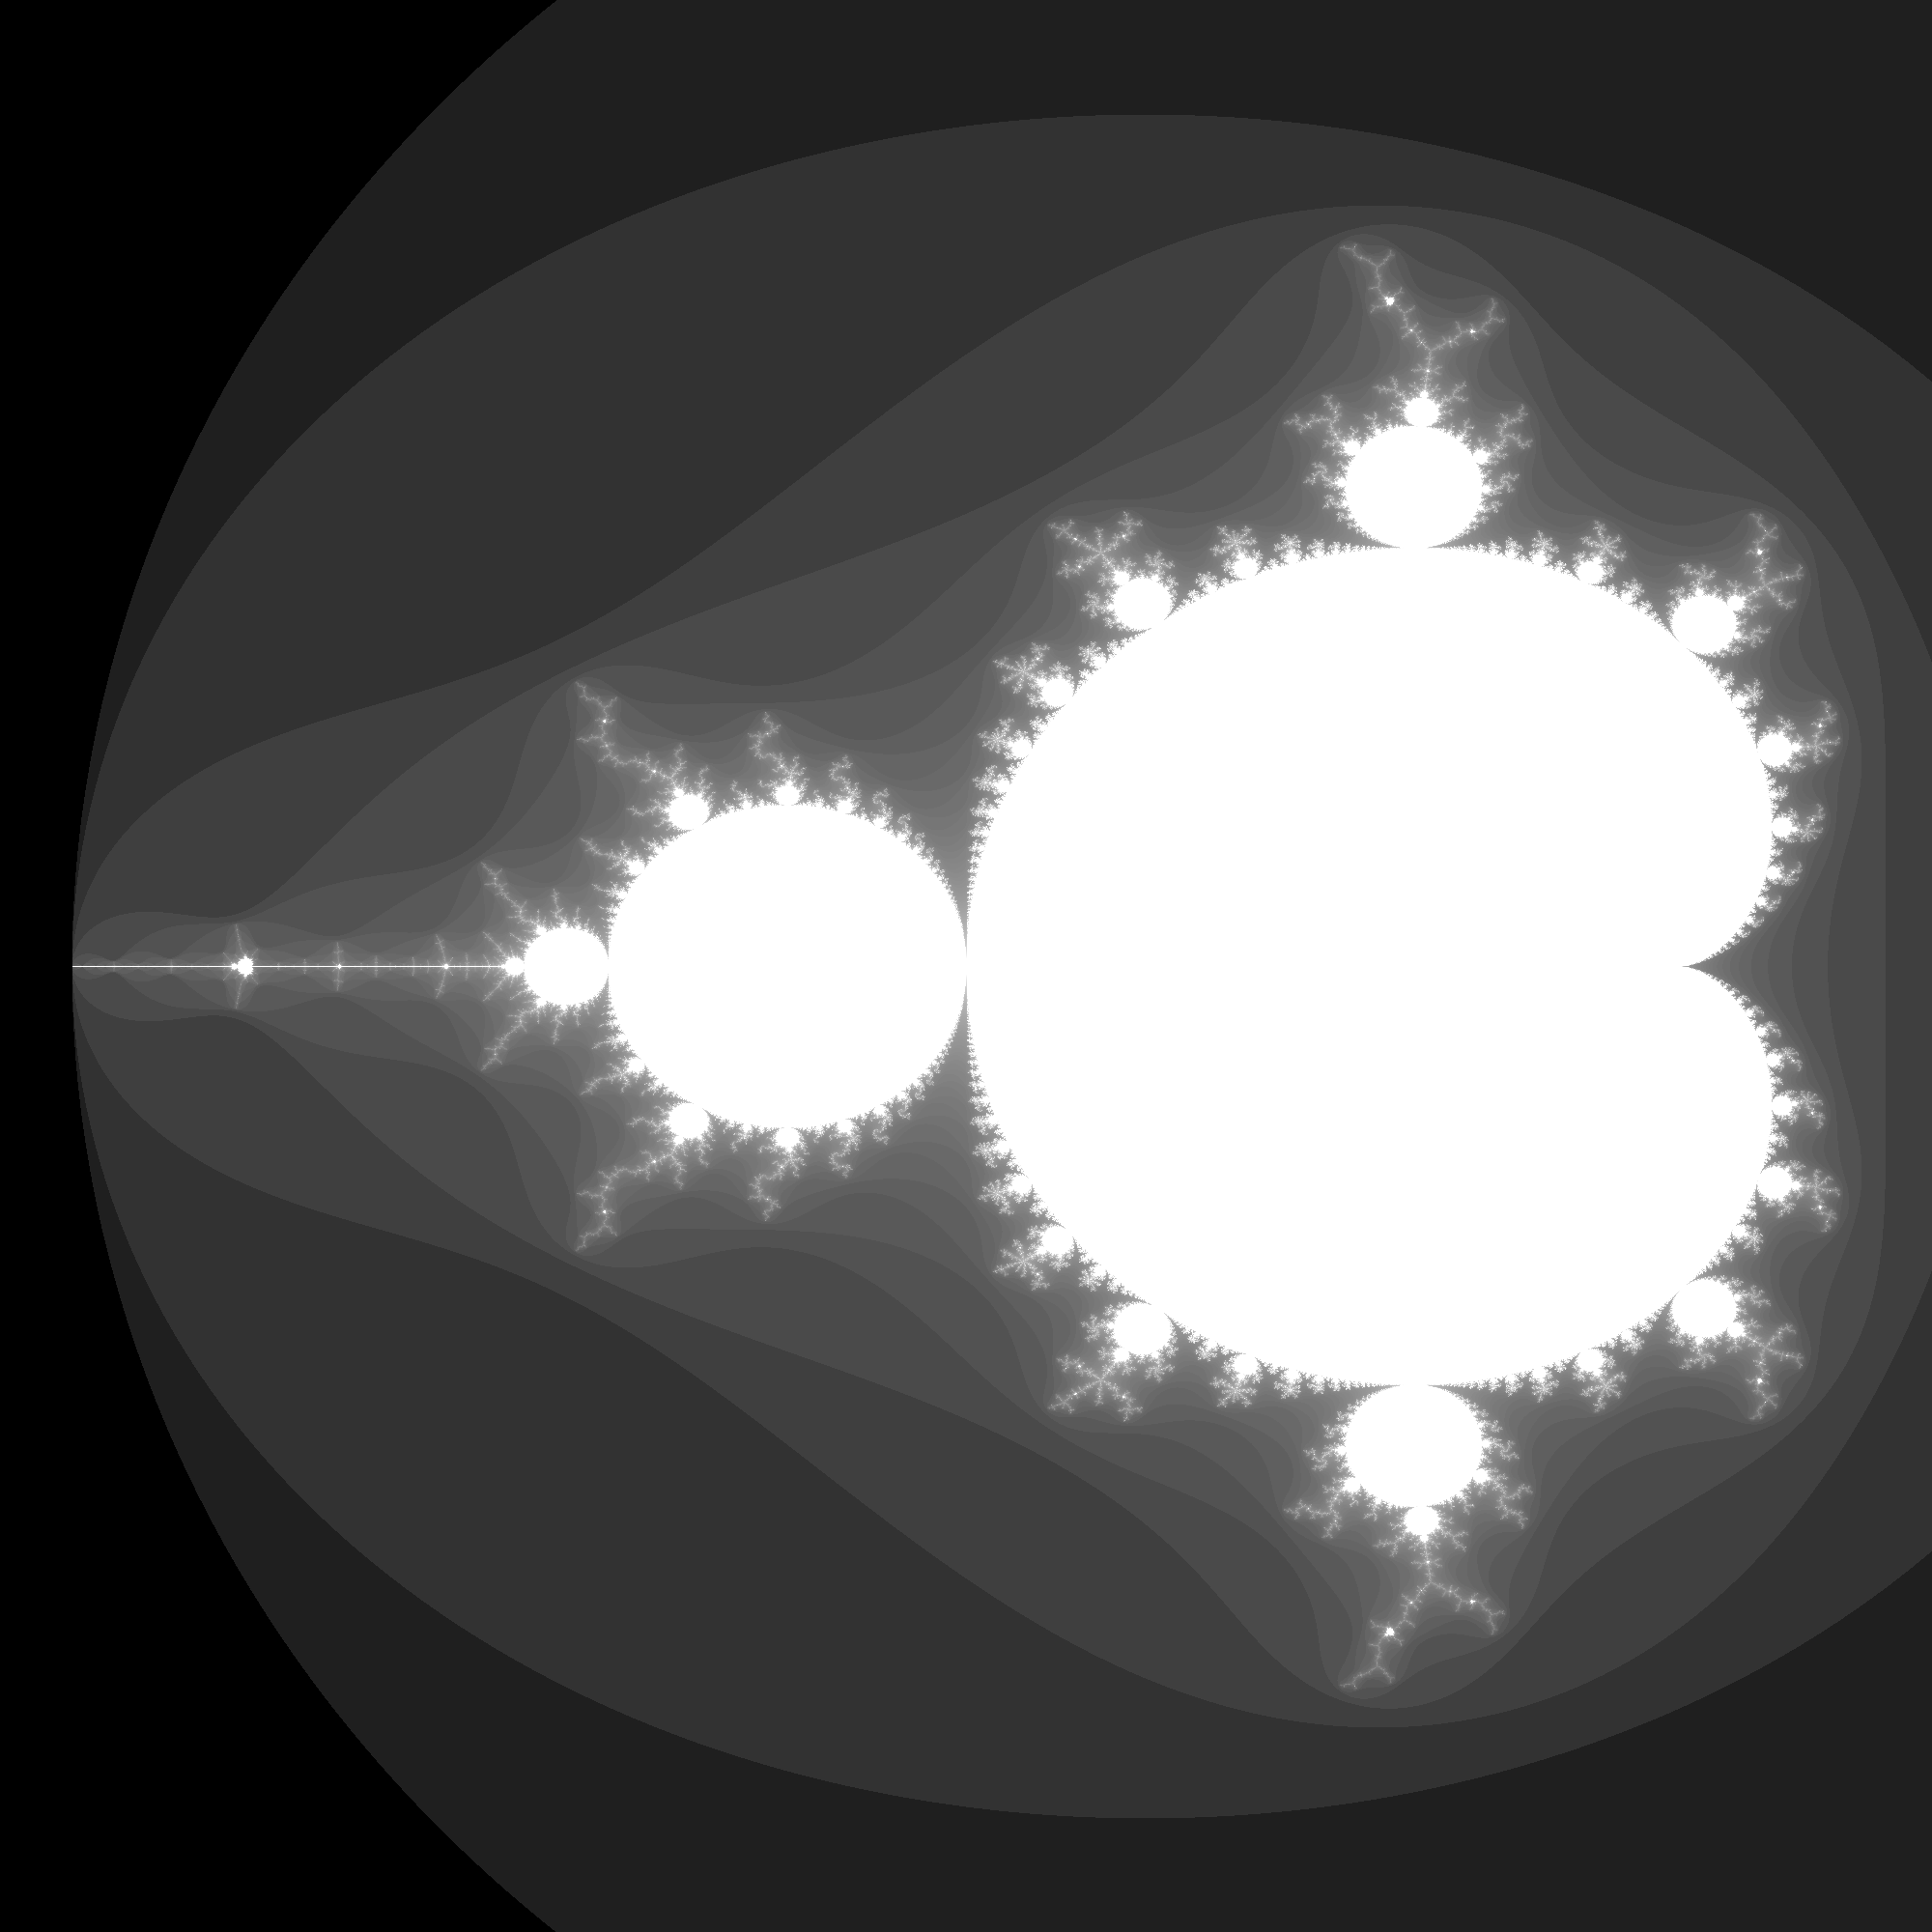

In [7]:
from PIL import Image

# convert values to 0 - 255 int8 format
img=np.log(img)
img = (img/img.max()*255).astype('uint8')
image = Image.fromarray(img)

display(image)

Next we define the interface for

void mandel(double *img, double re1, double re2, double im1, double im2,
	    int nr, int ni, int NTRIALS=255);

First we define the additional variable types we need (note we don't need to define c_double again!)

In [8]:
from ctypes import c_int
from ctypes import POINTER

In [9]:
myclib.mandel.argtypes = [POINTER(c_double), c_double, c_double, c_double, c_double, c_int, c_int, c_int]
myclib.mandel.restype=None

In [10]:
img=np.ndarray(shape=(npX,npY), dtype=np.double) # array to hold our image
%time myclib.mandel(img.ctypes.data_as(POINTER(c_double)),re1,re2,im1,im2,npX,npY,nTrials)

CPU times: user 426 ms, sys: 4.85 ms, total: 431 ms
Wall time: 432 ms


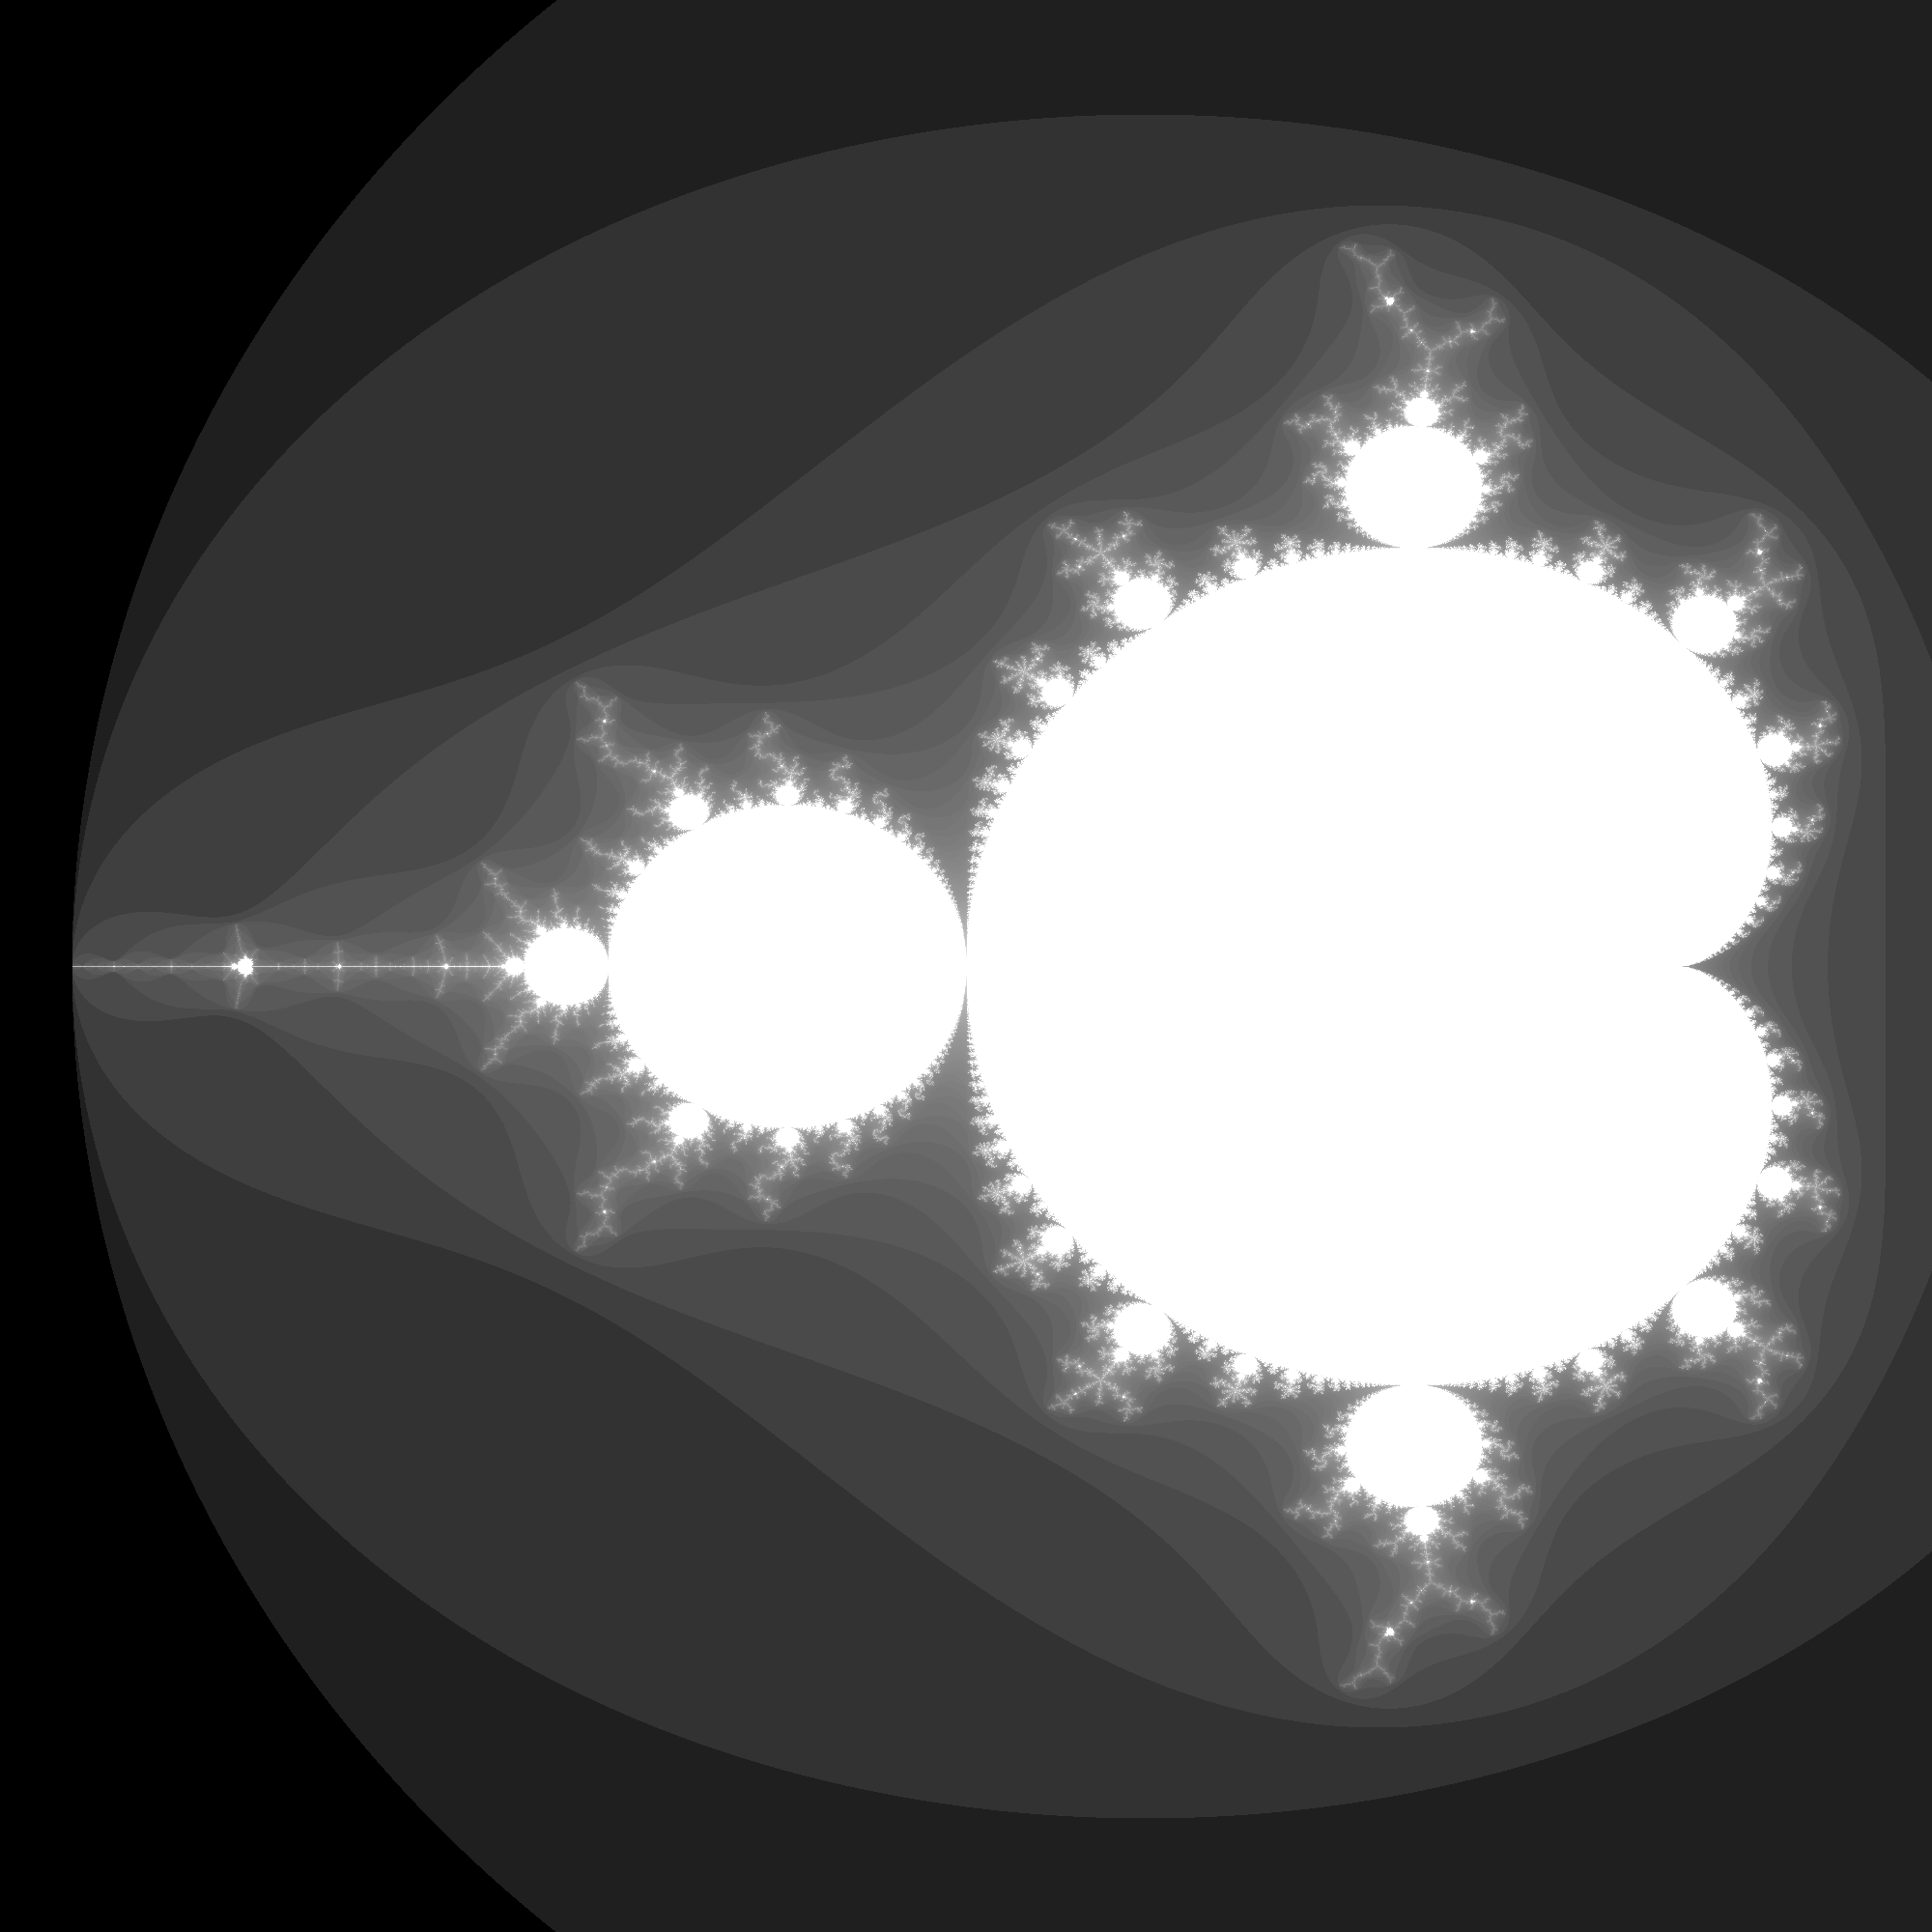

In [11]:
from PIL import Image

# convert values to 0 - 255 int8 format
img=np.log(img)
img = (img/img.max()*255).astype('uint8')
image = Image.fromarray(img)

display(image)

#image = Image.fromarray(img)
#img

Compare to the C example in C-to-Python.ipynb.  In this case you may see that numba is even faster, due to some optimizations that trigger parallelism in the CPU! This [site](https://tbetcke.github.io/hpc_lecture_notes/working_with_numba.html) includes a very detailed analysis of the optimizations performed by numba.

Homework project
=================


Project 2a
----------
Using numpy, see how fast you can perform the estimation of pi using 100M random numbers.  Compare your result to those above. Summarize your result and describe your speed up strategy in your README.md file.  Push your updates to Github.

In [17]:
import numpy
# I asked Copilot what it should be like to use numpy for this
# In my gut, I'm imagining you just use numpy to make 2 100M numpy 1D arrays of random numbers between -1 and 1.
# Then, for each pair, you check if it's in the circle or outside the circle.

# But, what Copilot gave me is just a little different.
# You make 100M points.
# You make the RNG seed.
# Then, r is just a numpy array with 2 rows, each row has 100M random points.
# That means the rows of r are x and y, and the column is coordinate pairs in x:[0,1), y:[0, 1)
# Then, the next line is a python one-liner that tries to solve this really quickly.
# Basically, let's start from the inside. r*r is multiplying each element by itself. So, x1*x1, x2*x2 and y3*y3 for example.
# .sum(axis = 0) means to add each pair x^2 and y^2 in each column. Axis = 0 is the columns!
# Looking just at the first quadrant, if x^2 + y^2 is < or = 1.0, you're inside the circle. Else, outside.
# So, np.mean() is just taking the average of all of these boolean statements.
# However, each boolean is just 0 or 1. 0 if you're outside, 1 if you're inside. So this is actually just the count in / count total.
# Finally, you need to multiply 4, since this is just 1 quadrant; need the other 3.

def findPi_numpy(n_points = 100*1000*1000):
    rng = np.random.default_rng(2025) # seed
    r = rng.random((2, n_points))
    pi_est = 4 * np.mean((r*r).sum(axis = 0) <= 1.0)
    print(pi_est)

%time PI=findPi_numpy(100*1000*1000)
print("Estimate for pi:",PI)


3.14154784
CPU times: user 851 ms, sys: 347 ms, total: 1.2 s
Wall time: 1.33 s
Estimate for pi: None


In [18]:
%%timeit -r1 -n1
a=None  # your code here

458 ns ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Project 2b (5630 only)
---------------------

In the sample C++ library, add a function HSVolume(d, N, r) that return the volume of a d-dimensional hypersphere with radius, r, using N pseudo random points.  Using the ctypes interface to call this function in Python and make the plot of the error on your calculation of the volume vs N, for N on the range of $1 ... 10^9$


In [ ]:
# The code for this is pretty simple. Honestly, it doesn't need to be any more complex than what we did in the previous class.

